In [ ]:
# !pip install psycopg2
# !pip install fpdf
# !pip install lorem

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from fpdf import FPDF
import lorem

In [ ]:
# Faz a conexão com o banco de dados
conn = psycopg2.connect(
    database="hk-qt",
    user="postgres",
    password="postdba",
    host="localhost",
    port="5433"
)

# Consulta SQL
query_client = "SELECT income as value_income, username as name, user_id as id FROM app_client JOIN auth_user as au on app_client.user_id = au.id"
query_loan = "SELECT * FROM app_loan"

# Executa a consulta e carrega os resultados em um DataFrame do Pandas
df_client = pd.read_sql_query(query_client, conn)
df_loan = pd.read_sql_query(query_loan, conn)

# Exibe o DataFrame com os resultados
#print(df)

In [189]:
# Fecha a conexão com o banco de dados
conn.close()

In [4]:
#creating new columns to improve analysis
df_client.insert(0,'score_credit','')
df_client.insert(0,'description_category','')

In [5]:
new_cols = ['id','name','score_credit', 'value_income','description_category']
df_client = df_client[new_cols]

In [6]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    21 non-null     int64 
 1   name                  21 non-null     object
 2   score_credit          21 non-null     object
 3   value_income          21 non-null     int64 
 4   description_category  21 non-null     object
dtypes: int64(2), object(3)
memory usage: 968.0+ bytes


In [9]:
df_client.head()

,id,name,score_credit,value_income,description_category
0,1,login1,,2000,
1,2,login2,,1800,
2,3,login3,,2500,
3,4,login4,,1900,
4,5,login5,,9000,


In [10]:
#business logic about loan for client, where i classify the client

for i in df_client:
    df_client['score_credit'] = np.where(df_client['value_income'] <= 2999, 1, df_client['score_credit'])
    df_client['score_credit'] = np.where( (df_client['value_income'] >= 3000) & (df_client['value_income'] <= 5999), 2, df_client['score_credit'])
    df_client['score_credit'] = np.where( (df_client['value_income'] >= 6000) & (df_client['value_income'] <= 8999), 3, df_client['score_credit'])
    df_client['score_credit'] = np.where( (df_client['value_income'] >= 9000) & (df_client['value_income'] <= 14999), 4, df_client['score_credit'])
    df_client['score_credit'] = np.where( df_client['value_income'] >= 15000, 5, df_client['score_credit'] )


for y in df_client:
    df_client['description_category'] = np.where(df_client['score_credit'] == 1, 'low income', df_client['description_category'])
    df_client['description_category'] = np.where(df_client['score_credit'] == 2, 'average income', df_client['description_category'])
    df_client['description_category'] = np.where(df_client['score_credit'] == 3, 'upper middle income', df_client['description_category'])
    df_client['description_category'] = np.where(df_client['score_credit'] == 4, 'high income', df_client['description_category'])
    df_client['description_category'] = np.where(df_client['score_credit'] == 5, 'big investors', df_client['description_category'])

In [11]:
df_client

,id,name,score_credit,value_income,description_category
0,1,login1,1,2000,low income
1,2,login2,1,1800,low income
2,3,login3,1,2500,low income
3,4,login4,1,1900,low income
4,5,login5,4,9000,high income
5,6,login6,1,1700,low income
6,7,login7,5,25000,big investors
7,8,login8,5,30000,big investors
8,9,login9,2,3600,average income
9,10,login10,2,5500,average income


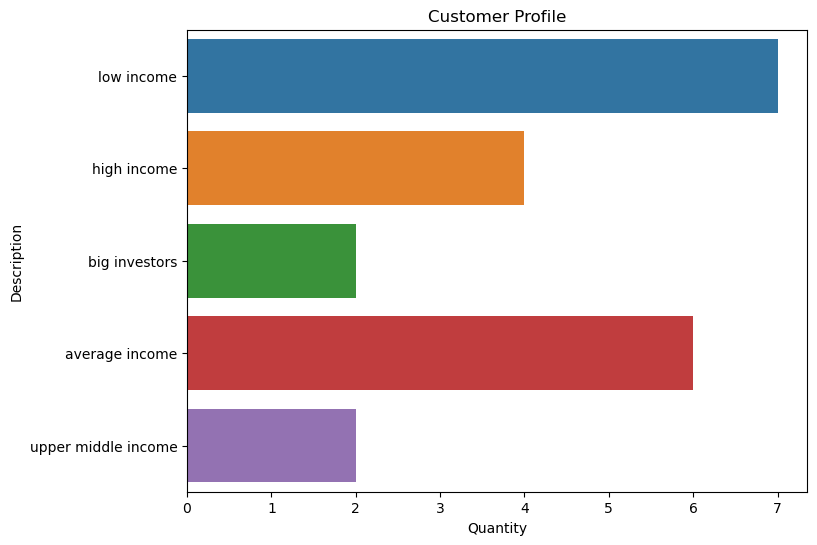

In [12]:
fig = plt.subplots(1,1, figsize = (8, 6))
sns.countplot(data=df_client, y='description_category')
plt.xlabel('Quantity')
plt.ylabel('Description')
plt.title('Customer Profile')

#plt.show()

plt.savefig('./Customers.png', 
           transparent=False,  
           facecolor='white', 
           bbox_inches="tight")

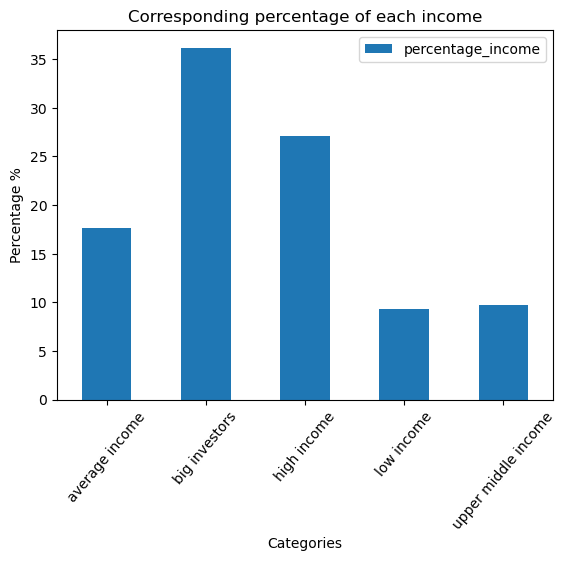

In [13]:
# gerando um gráfico para visualizar qual a porcentagem que cada categoria de cliente corresponde possui em relação todas as rendas

gp_percentage = (df_client.groupby('description_category')[['value_income']].sum() / df_client.groupby('description_category')[['value_income']].sum().sum() ) * 100

gp_percentage.rename(columns={'value_income':'percentage_income'}, inplace=True)

gp_percentage.plot(kind='bar', title='Corresponding percentage of each income', rot=50)
plt.xlabel('Categories')
plt.ylabel('Percentage %')

plt.savefig('./incomePercentage.png', 
           transparent=False,  
           facecolor='white', 
           bbox_inches="tight")

In [14]:
gp_percentage

,percentage_income
description_category,
average income,17.598684
big investors,36.184211
high income,27.138158
low income,9.309211
upper middle income,9.769737


#### Handling the loan table

In [18]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         20 non-null     int64         
 1   value      0 non-null      float64       
 2   start      20 non-null     datetime64[ns]
 3   end        20 non-null     datetime64[ns]
 4   status     20 non-null     object        
 5   client_id  20 non-null     int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 1.1+ KB


In [16]:
df_loan['start'] = pd.to_datetime(df_loan['start'])
df_loan['end'] = pd.to_datetime(df_loan['end'])
df_loan['value'] = pd.to_numeric(df_loan['value'])

In [19]:
#using merge for calculate the value loan
df_merge = pd.merge(df_client,df_loan, left_on='id', right_on='client_id', how='left')

In [20]:
for i in df_merge:
    df_merge['value'] = np.where( df_merge['score_credit'] == 1, df_merge['value_income'] * 0.15, df_merge['value'])
    df_merge['value'] = np.where( df_merge['score_credit'] == 2, df_merge['value_income'] * 0.25, df_merge['value'])
    df_merge['value'] = np.where( df_merge['score_credit'] == 3, df_merge['value_income'] * 0.35, df_merge['value'])
    df_merge['value'] = np.where( df_merge['score_credit'] == 4, df_merge['value_income'] * 0.45, df_merge['value'])
    df_merge['value'] = np.where( df_merge['score_credit'] == 5, df_merge['value_income'] * 0.50, df_merge['value'])

In [24]:
df_merge.head()

,id_x,name,score_credit,value_income,description_category,id_y,value,start,end,status,client_id
0,1,login1,1,2000,low income,1.0,300.0,2023-07-01,2023-08-01,,1.0
1,2,login2,1,1800,low income,2.0,270.0,2023-07-02,2023-08-02,,2.0
2,3,login3,1,2500,low income,3.0,375.0,2023-07-03,2023-08-03,,3.0
3,4,login4,1,1900,low income,4.0,285.0,2023-07-04,2023-08-04,,4.0
4,5,login5,4,9000,high income,5.0,4050.0,2023-07-05,2023-08-05,,5.0


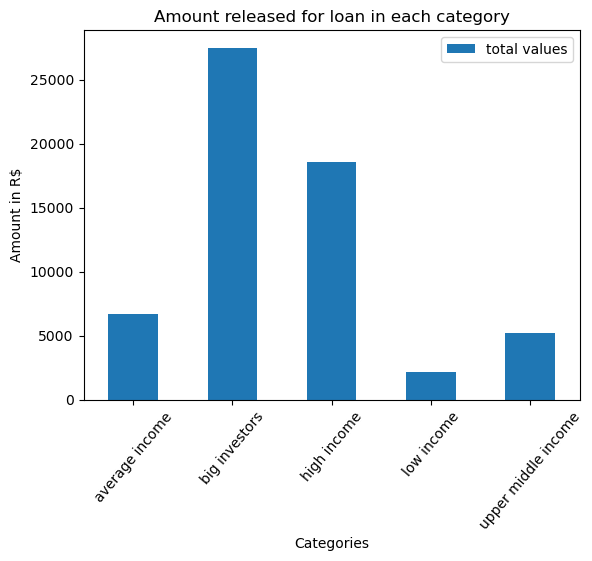

In [22]:
mount_money_loan = df_merge.groupby('description_category')[['value']].sum()
mount_money_loan.rename(columns={'value':'total values'}, inplace=True)

mount_money_loan.plot(kind='bar', title='Amount released for loan in each category', rot=50)
plt.xlabel('Categories')
plt.ylabel('Amount in R$')

plt.savefig('./totalLoan.png', 
           transparent=False,  
           facecolor='white', 
           bbox_inches="tight")

In [23]:
# generate a PDF for relatory
pdf = FPDF()
pdf.add_page()

# qtd lines
ch = 8
class PDF(FPDF):
    def __init__(self):
        super().__init__()
    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8, 'Hackathon - QT', 0, 1, 'C')
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')
        

pdf = PDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 24)
pdf.cell(w=0, h=20, txt="Customer loan report", ln=1, align='C')
pdf.set_font('Arial', '', 16)
pdf.cell(w=30, h=ch, txt="Date: ", ln=0)
pdf.cell(w=30, h=ch, txt="08/07/2023", ln=1)
pdf.ln(ch)
pdf.multi_cell(w=0, h=5, txt='Graphic report on the number of customers and their categories', align='C')
pdf.ln(ch)
pdf.image('./Customers.png', 
          x = 45, y = None, w = 100, h = 0, type = 'PNG')
pdf.ln(ch)

pdf.multi_cell(w=0, h=5, txt='Graphic report on the correspondence in percentage of each category in relation to incomes', align='C')
pdf.ln(ch)

pdf.image('./incomePercentage.png', 
          x = 50, y = None, w = 100, h = 0, type = 'PNG')
pdf.ln(ch)
pdf.ln(ch)

pdf.ln(ch)
pdf.ln(ch)
pdf.multi_cell(w=0, h=5, txt='Graphical report on the amount of money made available for each loan category', align='C')
pdf.ln(ch)

pdf.image('./totalLoan.png', 
          x = 51, y = None, w = 100, h = 0, type = 'PNG')


pdf.output(f'./customersRelatory.pdf', 'F')

''